In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:0000:01


In [2]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd


## Loading and preprocessing the data 

In [3]:
ratings = np.load('/kaggle/input/booksdata/ratings_final.npy')
kg_triples = pd.read_csv('/kaggle/input/booksdata/kg_final.txt', sep='\t', header=None)
kg_triples.columns = ['source', 'relation', 'target']

## Encoding user and book IDs

In [4]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()
ratings[:, 0] = user_encoder.fit_transform(ratings[:, 0]) 
ratings[:, 1] = book_encoder.fit_transform(ratings[:, 1])  

## Prepareing edges and edge types for the knowledge graph

In [5]:
source = torch.tensor(kg_triples['source'].values, dtype=torch.long)
relation = torch.tensor(kg_triples['relation'].values, dtype=torch.long)
target = torch.tensor(kg_triples['target'].values, dtype=torch.long)

In [6]:
user_book_edges = torch.tensor(ratings[:, :2], dtype=torch.long).T
user_book_relation_type = torch.full((user_book_edges.size(1),), fill_value=relation.max() + 1, dtype=torch.long)

all_edges = torch.cat([torch.stack([source, target]), user_book_edges], dim=1)
all_relations = torch.cat([relation, user_book_relation_type], dim=0)

all_edges, all_relations = to_undirected(all_edges, all_relations)

## Creating the graph data structure

In [7]:
num_nodes = all_edges.max().item() + 1
num_relations = all_relations.max().item() + 1  
feature_dim = 64  
data = Data(edge_index=all_edges, edge_type=all_relations)
data.x = F.normalize(torch.randn((num_nodes, feature_dim)), p=2, dim=1)  

## GNNRecommendationModel with dropout and weight decay

In [15]:
class GNNRecommendationModel(torch.nn.Module):
    def __init__(self, feature_dim, hidden_dim=128, num_relations=num_relations, dropout=0.3):
        super(GNNRecommendationModel, self).__init__()
        self.conv1 = RGCNConv(feature_dim, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, hidden_dim, num_relations)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        x = F.relu(self.conv1(x, edge_index, edge_type))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x

model = GNNRecommendationModel(feature_dim=data.x.size(1), hidden_dim=128, num_relations=num_relations)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-5)
margin_loss = torch.nn.TripletMarginLoss(margin=1.0)  

## Training

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_type)
    
    positive_edges = data.edge_index[:, :len(data.edge_index) // 2]  
    negative_edges = data.edge_index[:, len(data.edge_index) // 2:]  
    loss = margin_loss(out[positive_edges[0]], out[positive_edges[1]], out[negative_edges[1]])
    
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for a few epochs
for epoch in range(7):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 0.7627464532852173
Epoch 1, Loss: 0.8057863116264343
Epoch 2, Loss: 0.7655189037322998
Epoch 3, Loss: 0.5745282769203186
Epoch 4, Loss: 0.5142564177513123
Epoch 5, Loss: 0.5186865925788879
Epoch 6, Loss: 0.45638275146484375


## Books Recommendations

In [17]:
# Step 5: Recommend 7 books
def recommend(book_id, k=15):
    model.eval()
    with torch.no_grad():
        all_embeddings = model(data.x, data.edge_index, data.edge_type)
        book_embedding = all_embeddings[book_id]
        similarities = torch.cosine_similarity(book_embedding.unsqueeze(0), all_embeddings)
        recommended_books = similarities.topk(k + 1).indices[1:]  # Exclude the book itself
        valid_recommendations = [
            rec_id for rec_id in recommended_books.cpu().numpy() if rec_id < len(book_encoder.classes_)
        ]
        return book_encoder.inverse_transform(valid_recommendations[:k])

# Example usage
book_id = 0  # Example book ID for recommendation
recommended_books = recommend(book_id)
print("Recommended books:", recommended_books)

Recommended books: [12149  2108 13530  8582   106  3207  2351  3118  9146  6114 11418 13029
  7343]


# Visualizations

## Similarity Heatmap

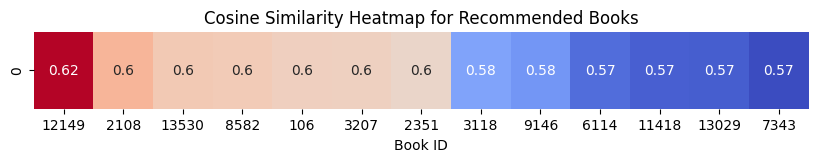

In [21]:
import seaborn as sns


def plot_similarity_heatmap(book_id, recommended_books, embeddings):
    book_embedding = embeddings[book_id].unsqueeze(0)
    similarities = torch.cosine_similarity(book_embedding, embeddings).cpu().numpy()

    relevant_similarities = similarities[recommended_books]

    plt.figure(figsize=(10, 1))
    sns.heatmap([relevant_similarities], annot=True, cmap="coolwarm", cbar=False, xticklabels=recommended_books)
    plt.title('Cosine Similarity Heatmap for Recommended Books')
    plt.xlabel('Book ID')
    plt.show()

    
with torch.no_grad():
    all_embeddings = model(data.x, all_edges, all_relations)
plot_similarity_heatmap(book_id, recommended_books, all_embeddings)

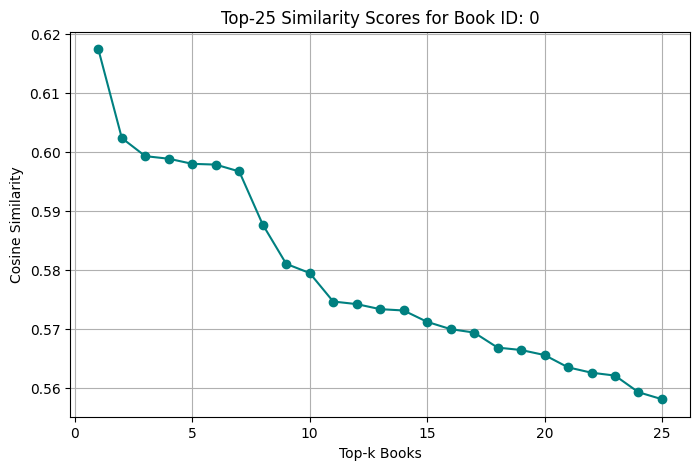

In [20]:
import matplotlib.pyplot as plt
def plot_top_k_similarities(book_id, embeddings, k=25):
    book_embedding = embeddings[book_id].unsqueeze(0)
    similarities = torch.cosine_similarity(book_embedding, embeddings, dim=1).cpu().numpy()

    top_k_similarities = np.sort(similarities)[::-1][1:k+1]

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, k+1), top_k_similarities, marker='o', color='teal')
    plt.title(f'Top-{k} Similarity Scores for Book ID: {book_id}')
    plt.xlabel('Top-k Books')
    plt.ylabel('Cosine Similarity')
    plt.grid(True)
    plt.show()

with torch.no_grad():
    all_embeddings = model(data.x, all_edges, all_relations)
plot_top_k_similarities(book_id, all_embeddings)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


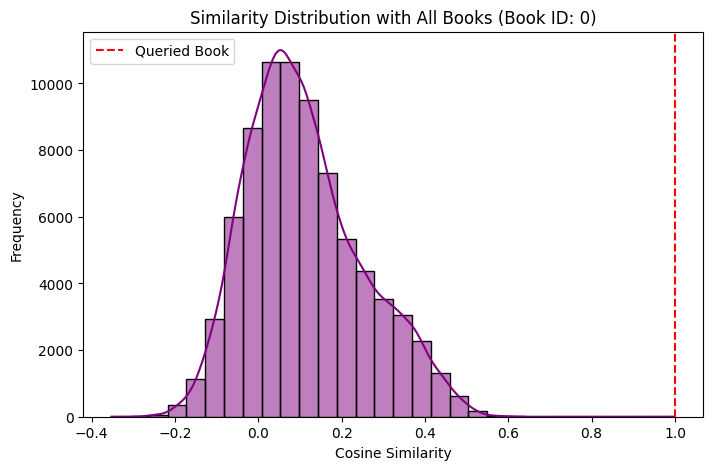

In [22]:
def plot_all_similarity_distribution(book_id, embeddings):
    book_embedding = embeddings[book_id].unsqueeze(0)
    similarities = torch.cosine_similarity(book_embedding, embeddings, dim=1).cpu().numpy()

    plt.figure(figsize=(8, 5))
    sns.histplot(similarities, kde=True, bins=30, color="purple")
    plt.axvline(x=similarities[book_id], color='red', linestyle='--', label='Queried Book')
    plt.title(f'Similarity Distribution with All Books (Book ID: {book_id})')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

with torch.no_grad():
    all_embeddings = model(data.x, all_edges, all_relations)
plot_all_similarity_distribution(book_id, all_embeddings)

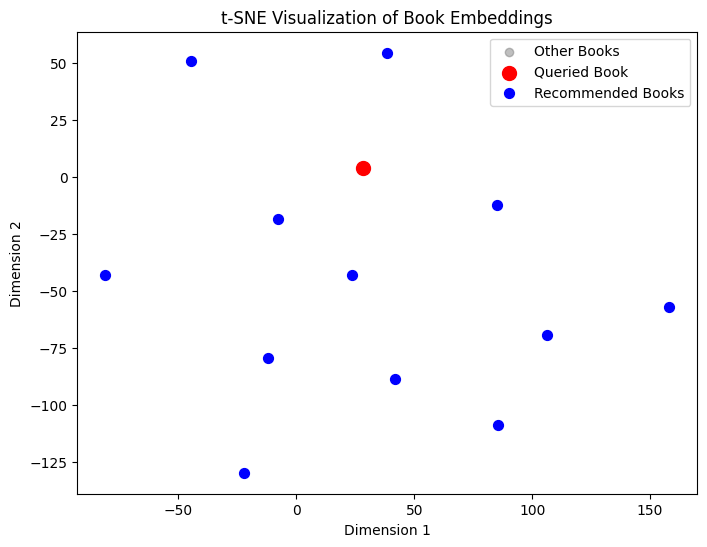

In [23]:
from sklearn.manifold import TSNE
import numpy as np

def plot_embedding_space(book_id, recommended_books, embeddings):
    selected_books = [book_id] + recommended_books
    selected_embeddings = embeddings[selected_books].cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(selected_books) - 1))
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='gray', alpha=0.5, label='Other Books')

    plt.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1], color='red', s=100, label='Queried Book')
    plt.scatter(reduced_embeddings[1:, 0], reduced_embeddings[1:, 1], color='blue', s=50, label='Recommended Books')

    plt.title('t-SNE Visualization of Book Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

with torch.no_grad():
    all_embeddings = model(data.x, all_edges, all_relations)
plot_embedding_space(book_id, recommended_books, all_embeddings)

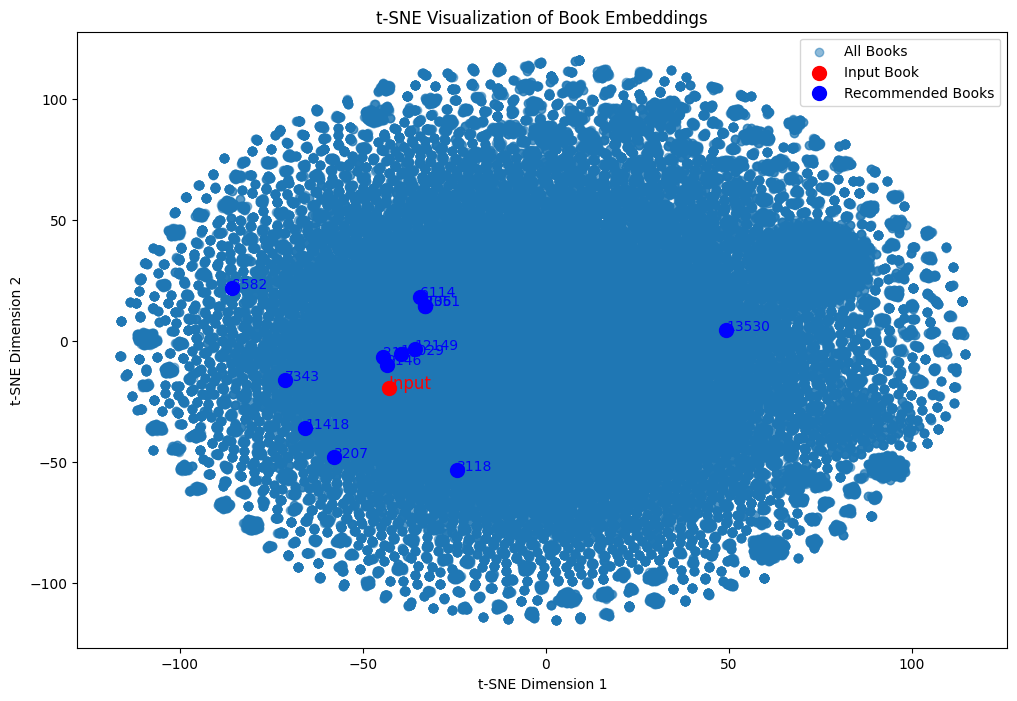

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_recommendations(book_id, recommended_books):
    model.eval()
    with torch.no_grad():
        all_embeddings = model(data.x, all_edges, all_relations).cpu().numpy()  # Adjusted to use all_edges and all_relations

    # Adjust perplexity based on the number of embeddings
    tsne_perplexity = min(5, len(all_embeddings) - 1)
    
    # Apply t-SNE to reduce the dimensions to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=tsne_perplexity)
    embeddings_2d = tsne.fit_transform(all_embeddings)
    
    # Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, label='All Books')
    
    # Highlight the input book and recommended books
    plt.scatter(embeddings_2d[book_id, 0], embeddings_2d[book_id, 1], color='red', label='Input Book', s=100)
    plt.scatter(embeddings_2d[recommended_books, 0], embeddings_2d[recommended_books, 1], color='blue', label='Recommended Books', s=100)
    
    # Annotate the input book and recommended books
    plt.text(embeddings_2d[book_id, 0], embeddings_2d[book_id, 1], 'Input', fontsize=12, color='red')
    for idx in recommended_books:
        plt.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1], str(idx), fontsize=10, color='blue')
    
    plt.title('t-SNE Visualization of Book Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

# Call the function with the given book ID and recommendations
visualize_recommendations(book_id, recommended_books)

## Visualising the dataset

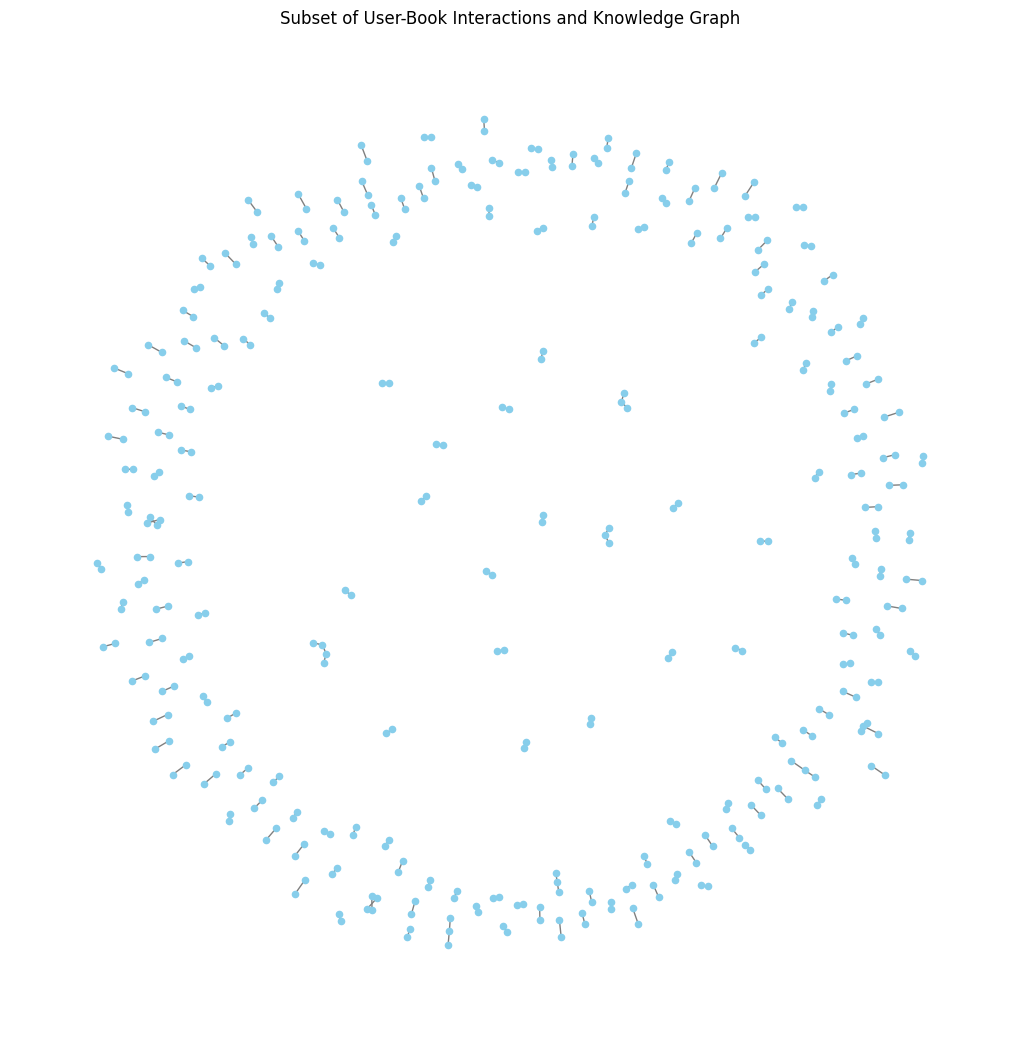

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Select a random subset of edges to visualize
num_edges_to_plot = 200  # Choose a manageable number for visualization
sample_edges = random.sample(range(all_edges.size(1)), num_edges_to_plot)
subset_edges = all_edges[:, sample_edges]

# Create a graph with networkx for visualization
G = nx.Graph()
for i in range(subset_edges.size(1)):
    source, target = subset_edges[:, i].numpy()
    G.add_edge(source, target)

# Plotting the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=20, node_color="skyblue", edge_color="gray")
plt.title("Subset of User-Book Interactions and Knowledge Graph")
plt.show()

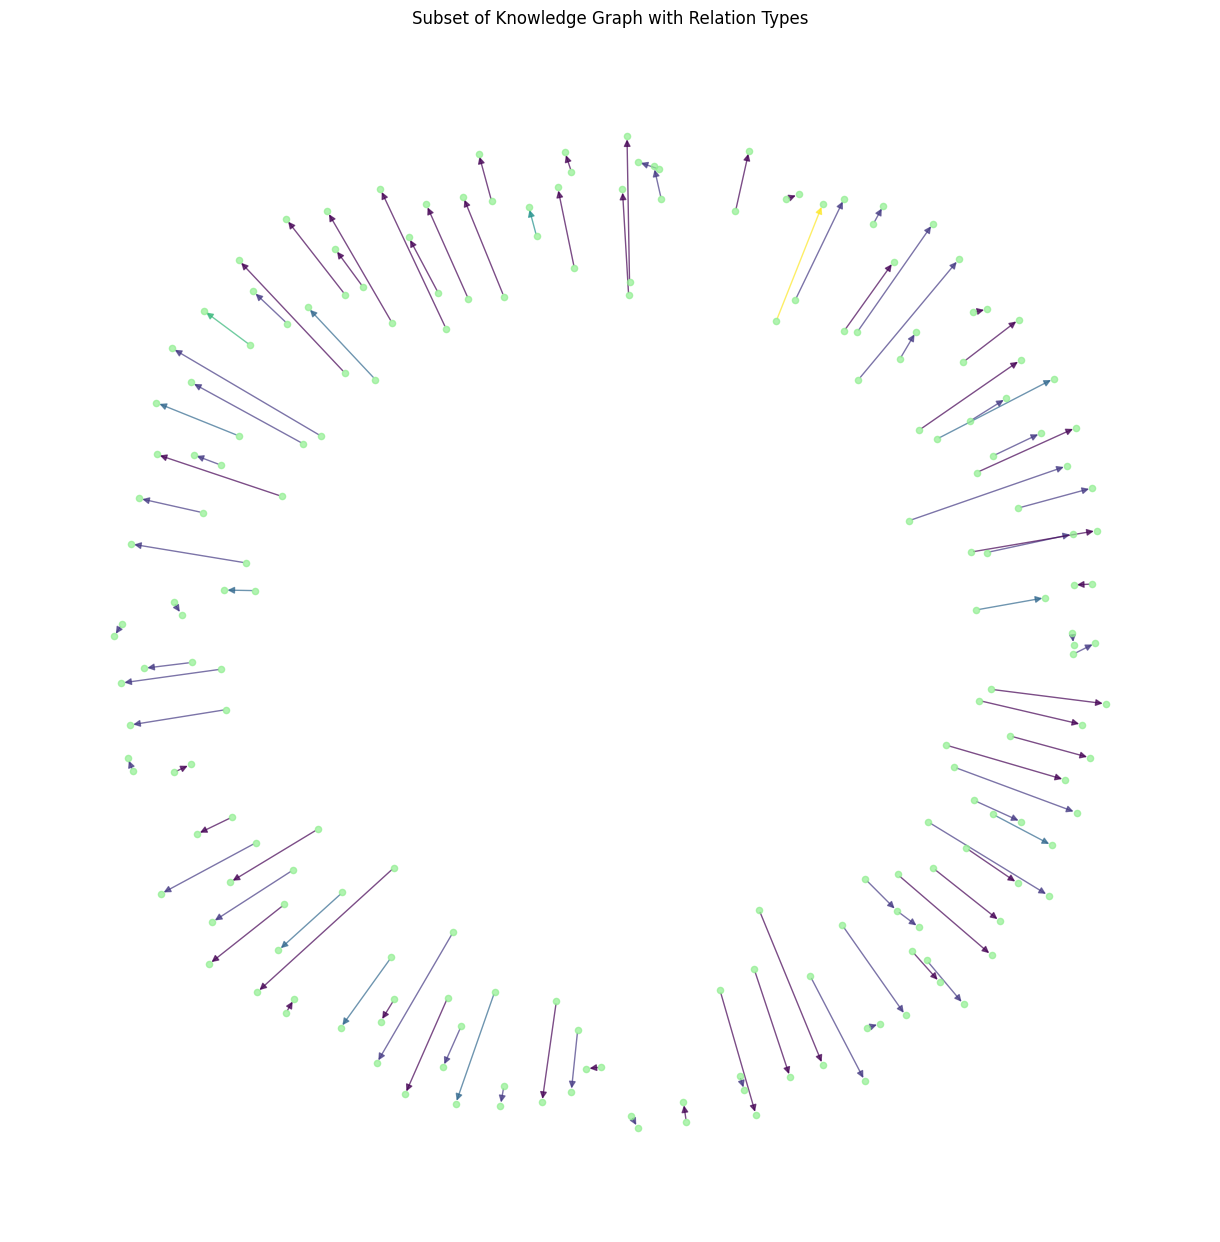

In [22]:
# Visualizing a subset of the knowledge graph with relation types
relation_sample_size = 100  # Number of relations to plot
sample_kg_edges = kg_triples.sample(n=relation_sample_size)

# Create a graph to visualize the knowledge graph subset
G_kg = nx.DiGraph()
edge_colors = []

for _, row in sample_kg_edges.iterrows():
    src, relation, tgt = row['source'], row['relation'], row['target']
    G_kg.add_edge(src, tgt, relation=relation)
    edge_colors.append(relation)

# Draw the knowledge graph subset with relation types
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_kg, seed=42)  # Spring layout for clear separation
nx.draw(G_kg, pos, with_labels=False, node_size=20, node_color="lightgreen", edge_color=edge_colors, alpha=0.7)
plt.title("Subset of Knowledge Graph with Relation Types")
plt.show()

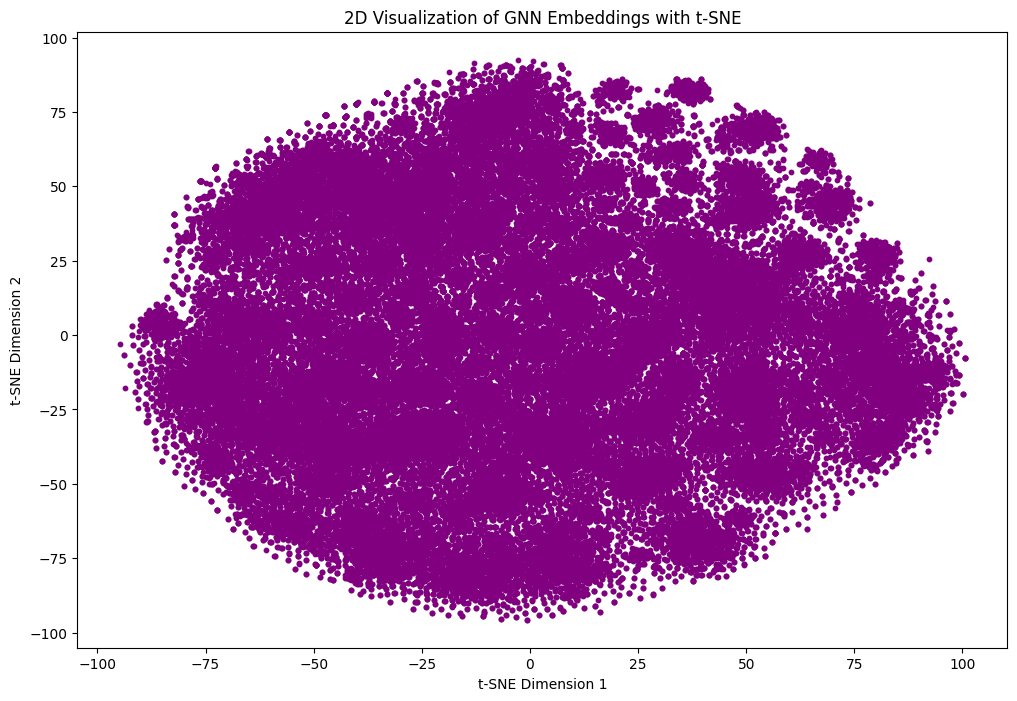

In [23]:
from sklearn.manifold import TSNE

# Extract embeddings from the trained model
model.eval()
with torch.no_grad():
    all_embeddings = model(data.x, data.edge_index).cpu().numpy()

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, color='purple')
plt.title("2D Visualization of GNN Embeddings with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()